In [ ]:
!pip install lime

In [ ]:
# for data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize
import string

# for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, svm
from sklearn.metrics import accuracy_score

# for explainer
from lime import lime_text

# for word embedding
import gensim
import gensim.downloader as gensim_api## for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks, preprocessing as kprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('book')

Importamos los datos desde un archivo csv a un DataFrame de Pandas.

In [ ]:
# df = pd.read_csv('drive/MyDrive/csv_files/base_completa_tr.csv')
df = pd.read_csv('drive/MyDrive/csv_files/base_completa_v2_headers.csv')
# df = pd.read_csv('base_completa_v2_headers.csv')

Renombramos los encabezados para no escribir tanto en el futuro y seguir una nomenclatura aceptada dentro del área de ML.

In [ ]:
df = df.rename(columns={"tipologia":"y", "traduccion":"text"})

Mandamos a imprimir 5 filas de forma aleatoria para observar los datos.

In [ ]:
df.sample(5)

,id,tweet,y,text
7381,7382,Reportaje: En 1950 9 vascos construyeron un ve...,amigo,Report: In 1950 9 Basques built a sailboat to ...
5751,5752,Drug smugglers are using catapults as a new wa...,enemigo,Drug smugglers are using catapults as a new wa...
1681,1682,Put Mexico On A Map Contest uses Google Sketch...,moderno,Put Mexico On A Map Contest uses Google Sketch...
4076,4077,"More than 28,000 people have died in drug-rela...",barbaro,"More than 28,000 people have died in drug-rela..."
438,439,"Governador do estado de Chiapas, no México, @V...",neutral,"Governor of the State of Chiapas, Mexico, @vel..."


Vamos a explorar brevemente la distribución de los datos según su clase por medio de un gráfico de barras horizontales.

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

A continuación, vamos a realizar una función para procesar el texto: limpieza, remover stopwords, y normalizar mediante lematización o stemming. Esta función se puede mapear en un DataFrame y esta forma, procesar toda una columna de texto.

In [ ]:
def get_wordnet_pos(treebank_tag):

	if treebank_tag.startswith('J'):
		return nltk.corpus.wordnet.ADJ
	elif treebank_tag.startswith('V'):
		return nltk.corpus.wordnet.VERB
	elif treebank_tag.startswith('N'):
		return nltk.corpus.wordnet.NOUN
	elif treebank_tag.startswith('R'):
		return nltk.corpus.wordnet.ADV
	else:
		return nltk.corpus.wordnet.NOUN

In [ ]:
def my_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

  # quitamos hashtags
  clean_tweet = re.sub('#[A-Za-z0-9_]+', '', text)

  # quitamos cashtags
  clean_tweet = re.sub('\$[A-Za-z0-9_]+', '', clean_tweet)

  # quitamos nosmbres de usuario
  clean_tweet = re.sub('@[A-Za-z0-9_]+', '', clean_tweet)

  # quitamos enlaces
  clean_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', clean_tweet)

  # quitamos signos de puntuacion
  clean_tweet = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', clean_tweet)

  # quitamos numeros
  clean_tweet = re.sub('[0-9_]+', '', clean_tweet)

  # quitar caracteres repetidos
  clean_tweet = re.sub(r'(.)\1{2,}', r'\1', clean_tweet)

  # tokenizamos
  clean_tweet = word_tokenize(clean_tweet)

  # filtramos palabras vacias
  if (lst_stopwords is not None):
    clean_tweet = [word for word in clean_tweet if word not in lst_stopwords]
  
  # Stemming (remove -ing, -ly, ...)
  if (flg_stemm == True):
    ps = nltk.stem.porter.PorterStemmer()
    clean_tweet = [ps.stem(word) for word in clean_tweet]
                
  # Lematizacion
  if flg_lemm == True:
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    tags = nltk.pos_tag(clean_tweet)
    clean_tweet = [wnl.lemmatize(j[0],get_wordnet_pos(j[1])) for j in tags]
            
  # volvemos a jutar las palabras en una oracion
  text = " ".join(clean_tweet)
  return text

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  ## clean (convert to lowercase and remove punctuations and characters and then strip)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
  ## Tokenize (convert from string to list)
  lst_text = text.split()    ## remove Stopwords
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords]
                
  ## Stemming (remove -ing, -ly, ...)
  if flg_stemm == True:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
                
  ## Lemmatisation (convert the word into root word)
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
            
  ## back to string from list
  text = " ".join(lst_text)
  return text

In [ ]:
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
                                                                      lst_stopwords=nltk.corpus.stopwords.words("english")))

In [ ]:
# split train-test
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

# get target
y_train = df_train["y"].values
y_test = df_test["y"].values



---

Pasemos al siguiente modelo de lenguaje: embeddings mediante word2vec. Para este problema, vamos a calcular nuestros propios embeddings mediante unigramas, bigramas y trigramas con la ayuda de la libreria gensim.



In [ ]:
corpus = df_train["text_clean"]

# create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

#  detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

Para determinar "caseramente" word2vec, se debe determinar:

* El tamaño del vector de salida (arbitrario, se deja a libre elección).
* El tamaño de la ventana que barre el texto ($n$ palabras atrás y adelante, ubicándonos en la palabra objetivo).
* La forma de entrenamiento. word2vec cuenta con dos variantes: *skipgram* y *continuos bag of words*.

In [ ]:
# fit word2vec
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)

¿Cómo se utilizan estos vectores para clasificar? Las entradas de los vectores son los pesos de una red neuronal, por lo que pueden utilizarse otra vez con esa idea.

* Primero, transformamos el corpus en secuencias y rellenamos los espacios (el tamaño de cada texto vectorizado debe ser igual, por lo que rellenamos con espacios vacíos) de identificadores de palabras para obtener una matriz de características.
* Luego, creamos una matriz de embeddings para que el vector de la palabra con id $n$ se ubique en la fila $n$.
* Finalmente, se construye una red neuronal con una capa de embeddings que pesa cada palabra en las secuencias con el vector correspondiente

Empecemos pasando el texto a tokens por medio de la librería de Deep Learning Keras.

In [ ]:
# tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

# create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

# padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=20, padding="post", truncating="post")

Visualizemos la matriz `X_train`, que alberga todos los tuits del conjunto de entrenamiento. Noten que es menos dispersa y los espacios en blanco son el padding para que todos midan 15.

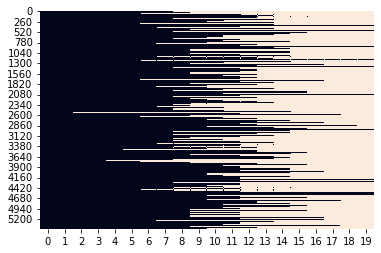

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Debemos haccer lo mismo con el conjunto de prueba.

In [ ]:
corpus = df_test["text_clean"]

# create list of n-grams
lst_corpus = []
for string in corpus:
  lst_words = string.split()
  lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
  lst_corpus.append(lst_grams)

# detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=20, padding="post", truncating="post")

Ya que tenemos `X_test` y `X_train`, debemos crear la matriz de embeddings que son los pesos que unen la capa de entrada con la capa intermedia de la red neuronal.

In [ ]:
# creamos una matriz con ceros
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word, idx in dic_vocabulary.items():
  # update the row with vector
  try:
   embeddings[idx] =  nlp[word]
  # if word not in model then skip and the row stays all 0s
  except:
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Este código genera una matriz de tamaño voc x 300 (tamaño del vocabulario x el tamaño del embedding).

In [ ]:
#  attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

# input
x_in = layers.Input(shape=(20,))

# embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=20, trainable=False)(x_in)
                     
# apply attention
x = attention_layer(x, neurons=20)

# 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2))(x)

# final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(18, activation='softmax')(x)

# compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      4711200     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 20)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 20)      420         ['permute[0][0]']                
                                                                                              

84


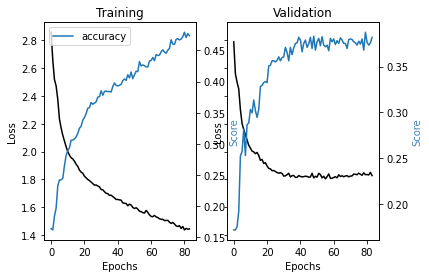

In [ ]:
# pasamos los valores de y a numeros
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

# entrenamos el modelo con early stopping
callback = callbacks.EarlyStopping(monitor='loss', patience=3)
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=100, shuffle=True, verbose=0, validation_split=0.3, callbacks=[callback])
print(len(training.history['loss']))

# plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
  ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
  ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
# test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
print(predicted)

['neutral', 'aliado', 'emergente', 'degradado', 'dependiente', 'degradado', 'emergente', 'marginal', 'independiente', 'marginal', 'emergente', 'degradado', 'adversario menor', 'marginal', 'emergente', 'emergente', 'marginal', 'marginal', 'barbaro', 'marginal', 'dependiente', 'emergente', 'emergente', 'marginal', 'emergente', 'emergente', 'cosmopolita', 'marginal', 'degradado', 'adversario menor', 'rival', 'dependiente', 'barbaro', 'emergente', 'adversario menor', 'dependiente', 'amigo', 'marginal', 'marginal', 'emergente', 'cosmopolita', 'marginal', 'emergente', 'emergente', 'barbaro', 'dependiente', 'marginal', 'marginal', 'independiente', 'marginal', 'emergente', 'exotico', 'marginal', 'barbaro', 'rival', 'exotico', 'barbaro', 'exotico', 'degradado', 'emergente', 'neutral', 'cosmopolita', 'cosmopolita', 'exotico', 'emergente', 'marginal', 'aliado', 'dependiente', 'marginal', 'emergente', 'marginal', 'marginal', 'marginal', 'emergente', 'degradado', 'emergente', 'dependiente', 'margin

In [ ]:
def plot2_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	Normalization can be applied by setting `normalize=True`.
	"""
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	print(cm)

	plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=45)
	plt.yticks(tick_marks, classes)

	fmt = '.1f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
	
	#plt.tight_layout()
	plt.ylabel('Clase correcta')
	plt.xlabel('Clase predicha')

In [ ]:
print(type(y_test))
print(type(predicted))

<class 'numpy.ndarray'>
<class 'list'>


In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, np.array(predicted))
# auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

plot2_confusion_matrix(cm, classes)


fig, ax = plt.subplots(nrows=1, ncols=2)
# Plot roc
for i in range(len(classes)):
  fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
  ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")

ax[0].legend(loc="lower right")
ax[0].grid(True)
    
# Plot precision-recall curve
for i in range(len(classes)):
  precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
  ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

AttributeError: ignored